In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import vectorbt as vbt
import matplotlib.pyplot as plt
import plotly.io as pio

In [2]:
# Prepare data
start = '2014-01-01'
end = '2024-01-01'
price = vbt.YFData.download('TSLA', start=start, end=end, interval='1d').get('Close')

# Benchmark Price of S&P 500
benchmark_price = vbt.YFData.download('ES=F', start=start, end=end, interval='1d').get('Close')

# Calculate the benchmark return (buy and hold)
benchmark_return = benchmark_price.pct_change().fillna(0).add(1).cumprod()

#price

In [3]:
# RSI Strategy - Buys above 50 and Sells below 50
rsi = vbt.RSI.run(price, window=14)  # Using 14-day RSI
entries = rsi.rsi_crossed_above(50)
exits = rsi.rsi_crossed_below(50)

# Set time frame
freq = '1d'  # daily frequency

# Create Benchmark Portfolio (Buy-and-Hold on ES=F)
benchmark_pf = vbt.Portfolio.from_holding(benchmark_price, init_cash=1000, freq=freq)

# # Create Portfolio for the strategy
pf = vbt.Portfolio.from_signals(price, entries, exits, init_cash=1000, freq=freq)

print("\nStrategy Performance:\n")
print(pf.stats())

print("\nBenchmark Performance (ES=F):\n")
print(benchmark_pf.stats())


Strategy Performance:

Start                          2013-12-31 05:00:00+00:00
End                            2023-12-29 05:00:00+00:00
Period                                2517 days 00:00:00
Start Value                                       1000.0
End Value                                   18549.283126
Total Return [%]                             1754.928313
Benchmark Return [%]                         2377.697032
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                                61.22408
Max Drawdown Duration                  594 days 00:00:00
Total Trades                                         132
Total Closed Trades                                  131
Total Open Trades                                      1
Open Trade PnL                                686.042982
Win Rate [%]                                   32.824427
Best Trade [%]                                209.887286
Worst T

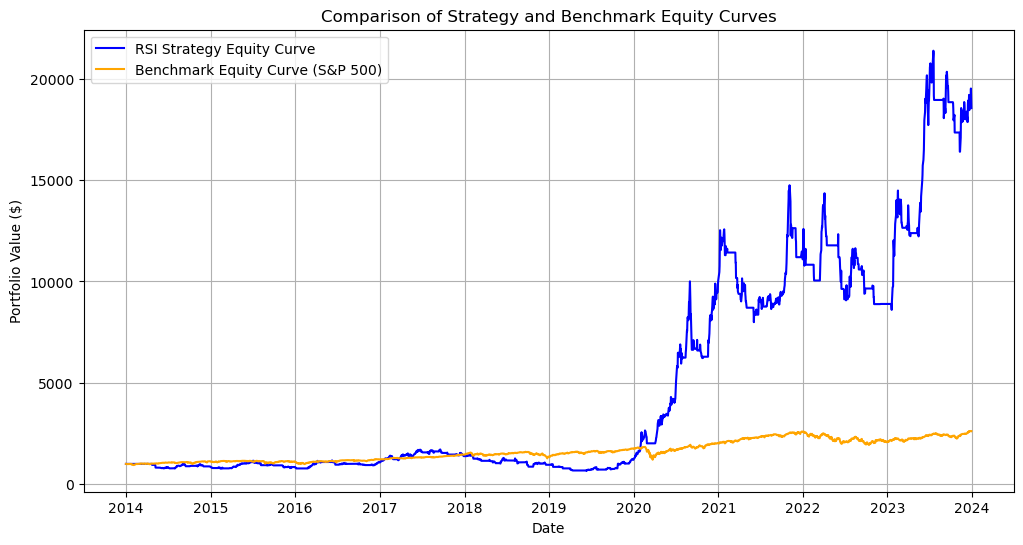

In [4]:
# Step 6: Plot the equity curve for both the RSI strategy and the benchmark
plt.figure(figsize=(12, 6))
plt.plot(pf.value(), label='RSI Strategy Equity Curve', color='blue')
plt.plot(benchmark_pf.value(), label='Benchmark Equity Curve (S&P 500)', color='orange')
plt.title('Comparison of Strategy and Benchmark Equity Curves')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.show()

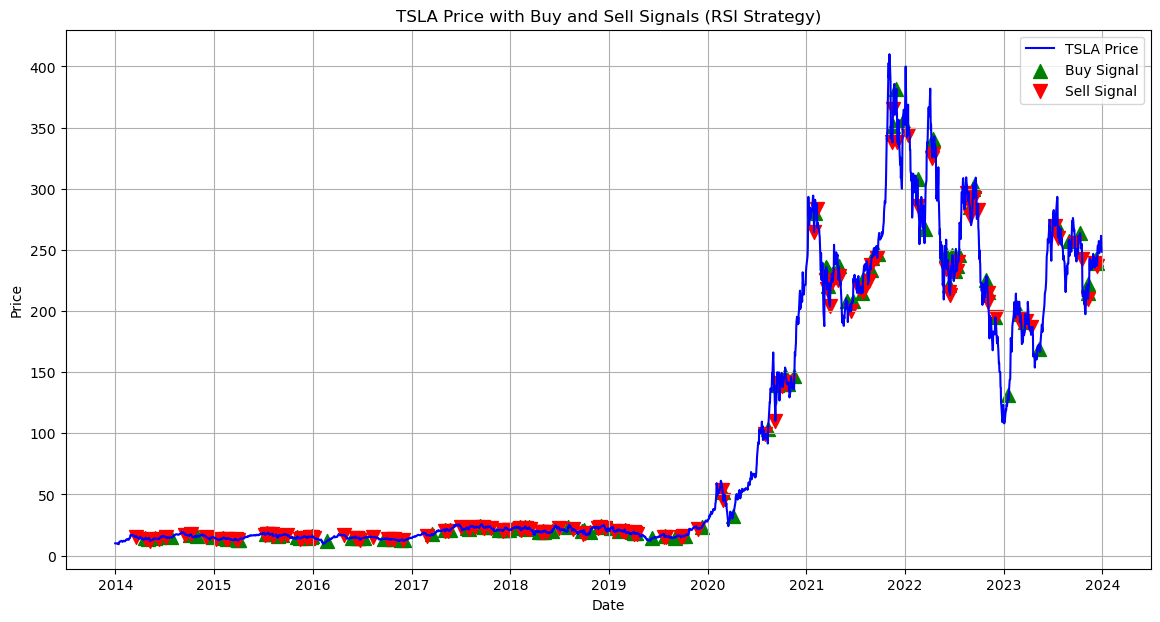

In [5]:
# Accessing the trades taken
trades = pf.trades  # This gives you the trades object

# Create a plot
plt.figure(figsize=(14, 7))

# Plot the price series
plt.plot(price.index, price, label='TSLA Price', color='blue')

# Plot entry points (buy signals)
plt.scatter(price.index[entries], price[entries], marker='^', color='green', s=100, label='Buy Signal')

# Plot exit points (sell signals)
plt.scatter(price.index[exits], price[exits], marker='v', color='red', s=100, label='Sell Signal')

# Add labels and legend
plt.title('TSLA Price with Buy and Sell Signals (RSI Strategy)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

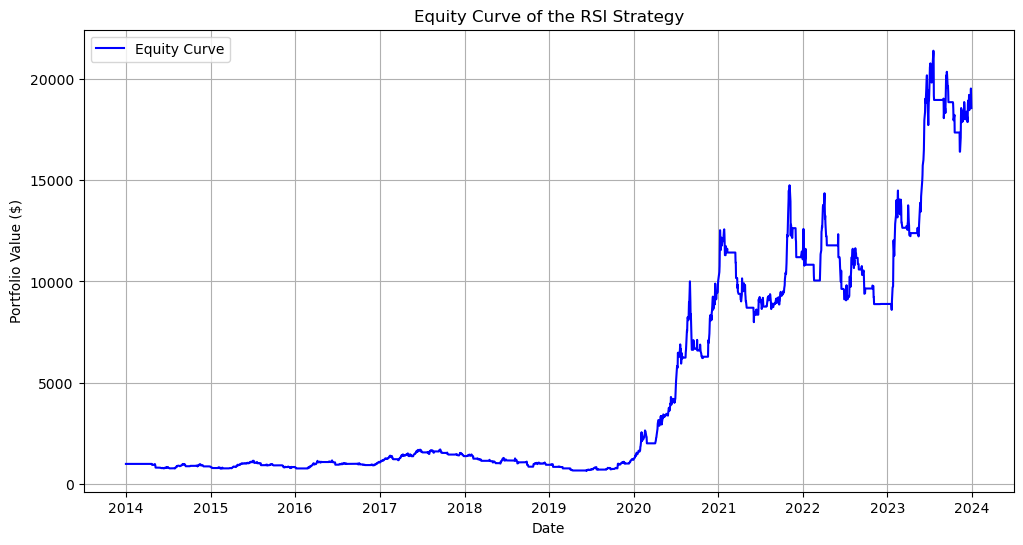

In [6]:
# Step 5: Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(pf.value(), label='Equity Curve', color='blue')
plt.title('Equity Curve of the RSI Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.show()

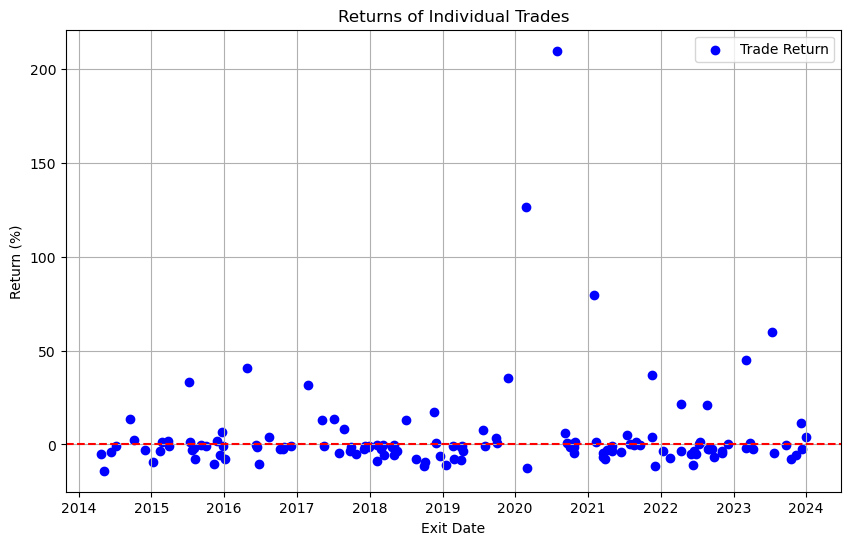

In [7]:
# Step 5: Accessing the trades taken
trades = pf.trades  # This gives you the trades object

# Use the correct column names based on your data
exit_dates = price.index[trades.records['exit_idx']]  # Getting the actual dates from the index
trade_returns = trades.records['return'] * 100

# Step 6: Create a scatter plot of returns of individual trades
plt.figure(figsize=(10, 6))
plt.scatter(exit_dates, trade_returns, color='blue', label='Trade Return')
plt.axhline(0, color='red', linestyle='--')  # Add a line at 0% return for reference
plt.title('Returns of Individual Trades')
plt.xlabel('Exit Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.legend()
plt.show()

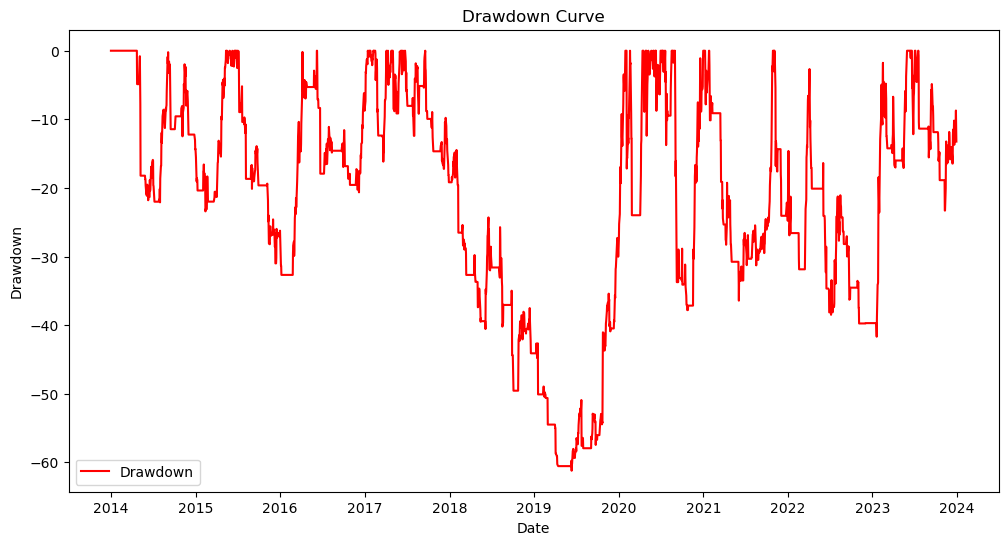

In [8]:
# Plot drawdown
plt.figure(figsize=(12, 6))
plt.plot(pf.drawdown() * 100, label='Drawdown', color='red')
plt.title('Drawdown Curve')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()


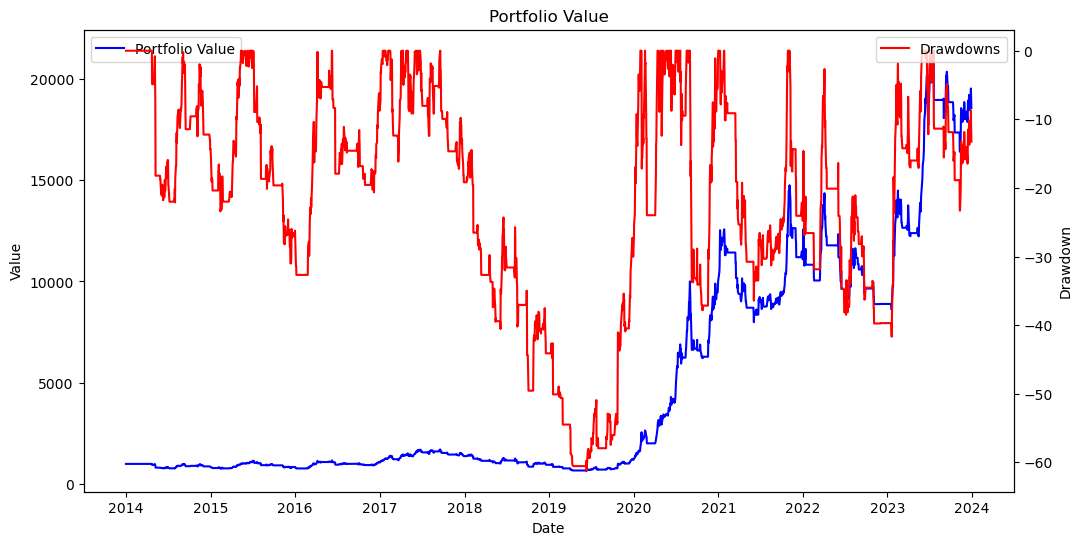

In [9]:
# Extract value and drawdowns from the portfolio
portfolio_value = pf.value()
drawdowns = pf.drawdown() * 100

# Plot portfolio value
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(portfolio_value, color='blue', label='Portfolio Value')
ax1.set_title('Portfolio Value')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')

# Create a second y-axis for drawdowns
ax2 = ax1.twinx()
ax2.plot(drawdowns, color='red', label='Drawdowns')
ax2.set_ylabel('Drawdown')
ax2.legend(loc='upper right')

plt.show()


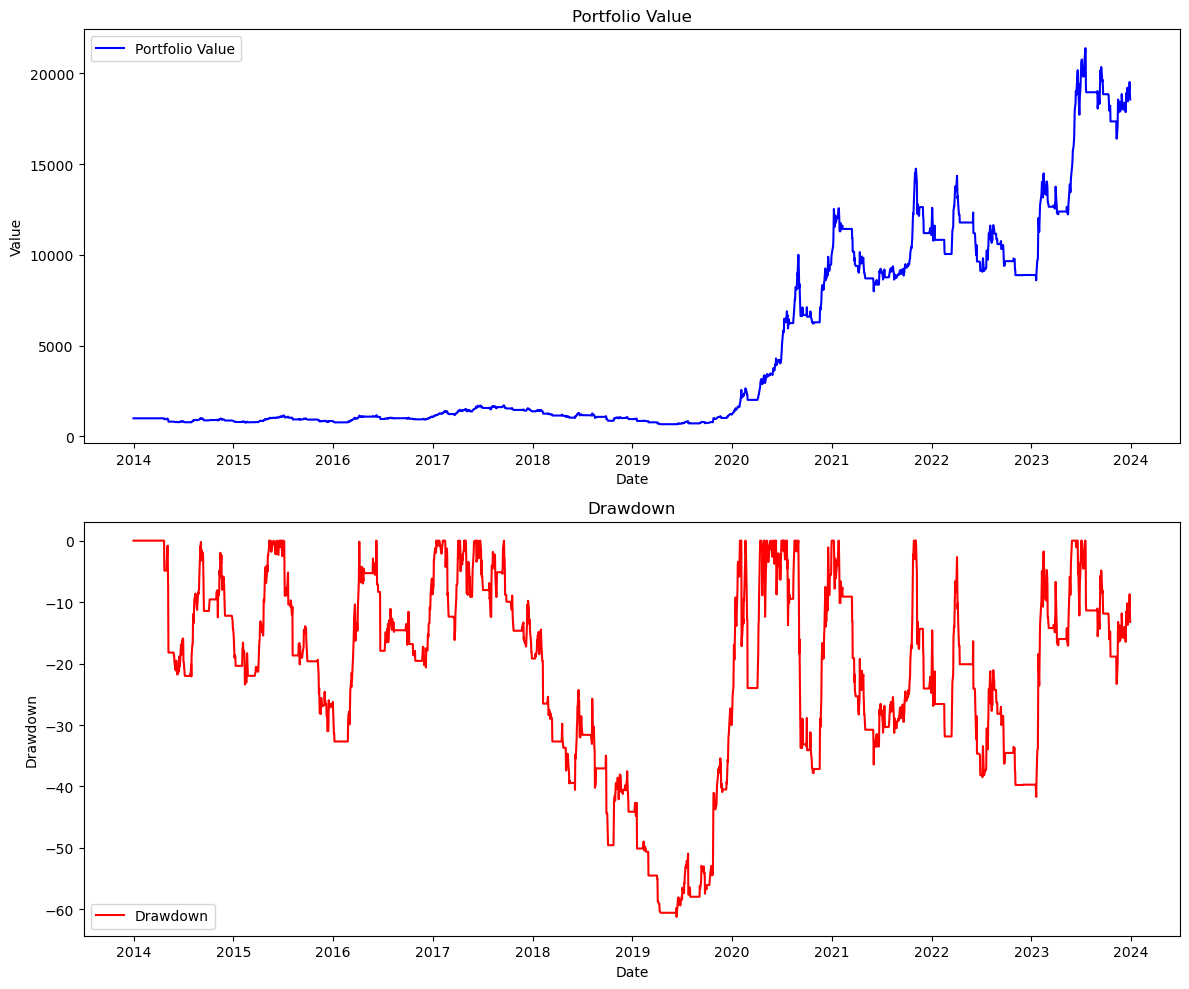

In [10]:
# Create a figure with two subplots: one for Portfolio Value and one for Drawdowns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the portfolio value on the first subplot (ax1)
ax1.plot(pf.value(), label='Portfolio Value', color='blue')
ax1.set_title('Portfolio Value')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
ax1.legend()

# Plot the drawdowns on the second subplot (ax2)
ax2.plot(pf.drawdown() * 100, label='Drawdown', color='red')
ax2.set_title('Drawdown')
ax2.set_xlabel('Date')
ax2.set_ylabel('Drawdown')
ax2.legend()

# Adjust the layout so that the subplots don't overlap
plt.tight_layout()

# Display the plot
plt.show()


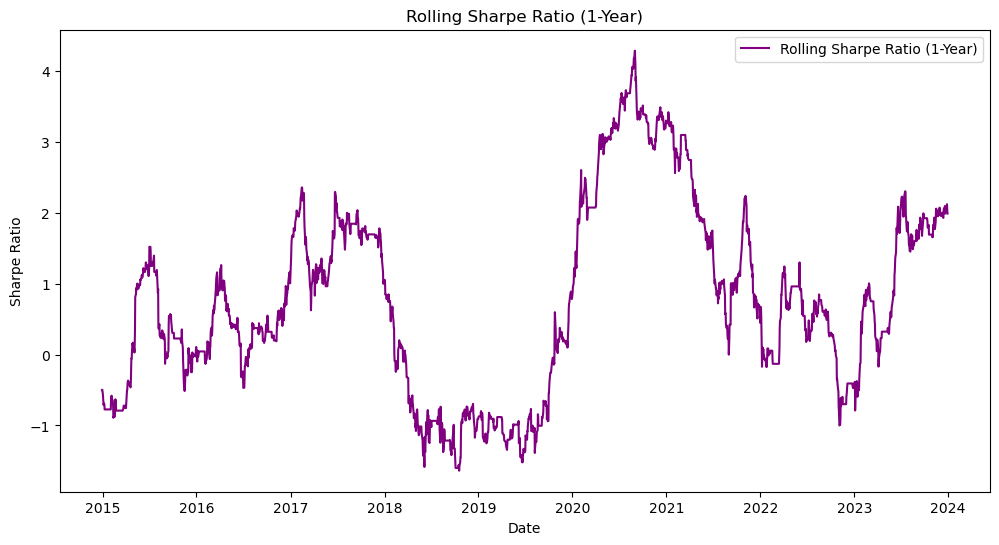

In [11]:
# Calculate daily returns
returns = pf.returns()

# Define the window size for the rolling calculation (e.g., 252 trading hours for 1 year)
window_size = 252

# Calculate rolling mean and standard deviation of returns
rolling_mean = returns.rolling(window=window_size).mean()
rolling_std = returns.rolling(window=window_size).std()

# Calculate the rolling Sharpe ratio (assuming risk-free rate = 0 for simplicity)
rolling_sharpe = rolling_mean / rolling_std * np.sqrt(window_size)

# Plot rolling Sharpe ratio
plt.figure(figsize=(12, 6))
plt.plot(rolling_sharpe, label='Rolling Sharpe Ratio (1-Year)', color='purple')
plt.title('Rolling Sharpe Ratio (1-Year)')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()
